## Семинар 2 "Распознавание рукописных цифр"

ФИО: 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [97]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    print(X.shape)
    print(y)
    break

(32, 784)
[9 7 1 9 3 7 2 2 2 1 9 1 6 3 6 6 9 0 1 2 3 4 8 3 9 5 3 7 8 4 1 3]


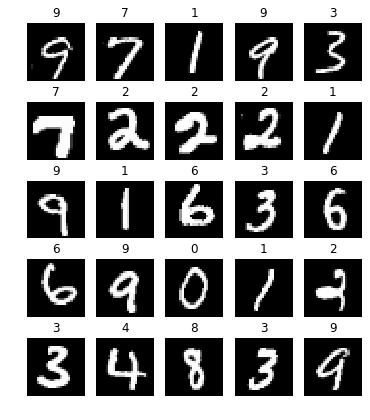

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [8]:
#activation = ReLU()
activation = Sigmoid()

inner_dim = 64

layers = [Linear(784, inner_dim), activation]
for i in range(1):
    layers.extend([Linear(inner_dim, inner_dim), activation])

layers.append(Linear(inner_dim, 10))

net = NeuralNetwork(layers)
loss = NLLLoss()

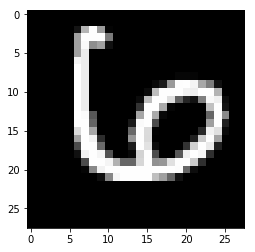

In [6]:
for X, y in train_loader:
    X = X.numpy()
    break
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)

In [16]:
x = net.forward(X[0].reshape(1, -1))[0]
order = np.argsort(x)[::-1]
print(order, x[order])

[4 3 8 0 7 5 2 6 9 1] [ 0.03744556  0.03098868  0.01199096  0.00565081  0.00229608  0.00187357
 -0.01245581 -0.02226498 -0.02709453 -0.08726306]


In [93]:
losses = []

## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    l = loss.forward(res, y)
    
    losses.append(l)
    
    dLdy = loss.backward()
    
    net.backward(dLdy)
    net.step(0.1)

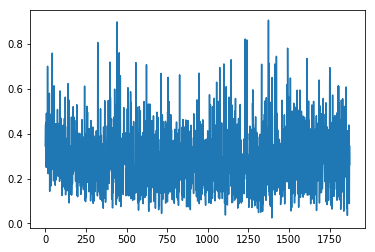

In [94]:
plt.plot(losses)
#plt.plot(sigm_losses)
#plt.plot(good_relu_losses)
plt.show()

In [89]:
good_relu_losses = losses

In [43]:
print(l)

0.7884153334874857


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [66]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = (X > 0).astype(float)*X
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s > 0).astype(float)*dLdy
    
    def step(self, learning_rate):
        pass

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [36]:
errors = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    
    for x_i, y_i in zip(X, y):
        l = loss.forward(x_i.reshape(1, -1), y_i.reshape(1, -1))
        errors.append((l, x_i.reshape(28, 28)))
    
    if len(errors) > 1000:
        break

### HW1 (1 балл): Реализовать Tanh

In [7]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.Y = 2 / (1 + np.exp(-2 * X)) - 1
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        tmp = 2 / (1 + np.exp(-2 * X))
        self.dLdx = tmp * (2 - tmp) * dLdy
        return self.dLdx
    
    def step(self, learning_rate):
        pass

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [102]:
def set_net(activation=Sigmoid()):
    inner_dim = 64
    layers = [Linear(784, inner_dim), activation, Linear(inner_dim, inner_dim)]
    net = NeuralNetwork(layers)
    return net

In [14]:
loss = NLLLoss()

In [52]:
from skimage.transform import rotate  

In [85]:
def rotate_(x):
    angle = 10
    s = int(x.flatten().shape[0] ** 0.5)
    x = x.reshape(s, s)
    return rotate(x, angle).flatten()

def noise(x):
    s = int(x.flatten().shape[0])
    x += np.random.randn(s) * 0.2
    return x

<function matplotlib.pyplot.show(*args, **kw)>

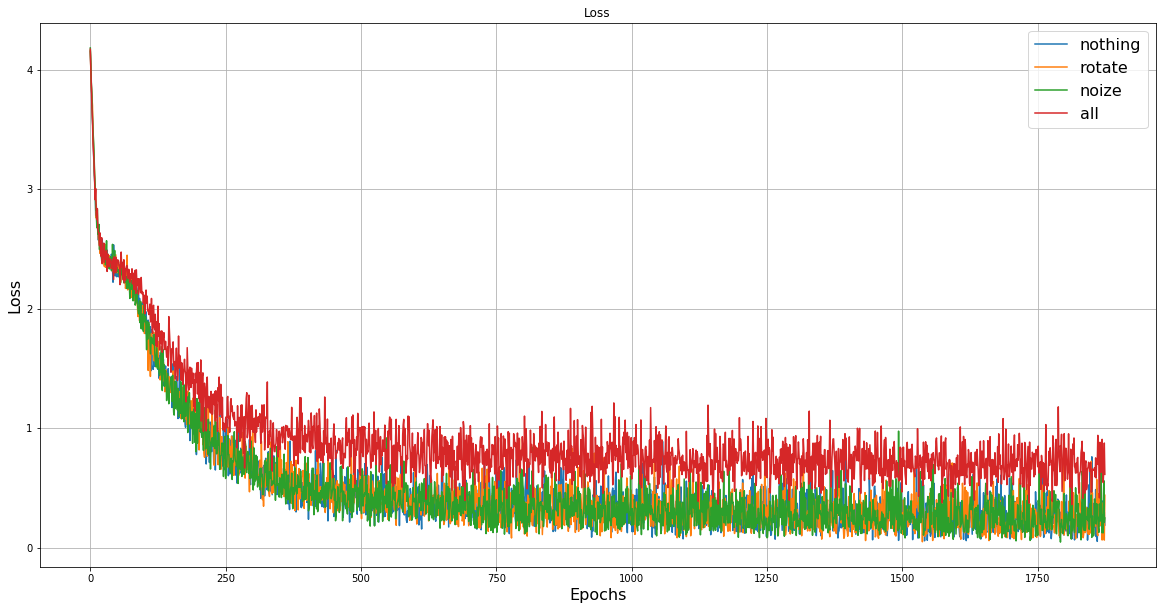

In [103]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title('Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
for par in ["nothing", "rotate", "noize", "all"]:
    losses = []
    net = set_net()
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        n_changes = int(y.shape[0] * 0.1)
        for i in range(n_changes):
            if par == "rotation":
                X[i] = rotate_(X[i])
            if par == "noize":
                X[i] == noise(X[i])
            if par == "all":
                X[i] = rotate_(X[i])
                X[i + n_changes] = noise(X[i])
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    plt.plot(losses, label=par)
plt.legend(loc=0, fontsize=16)
plt.show

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [104]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass
    

class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

<function matplotlib.pyplot.show(*args, **kw)>

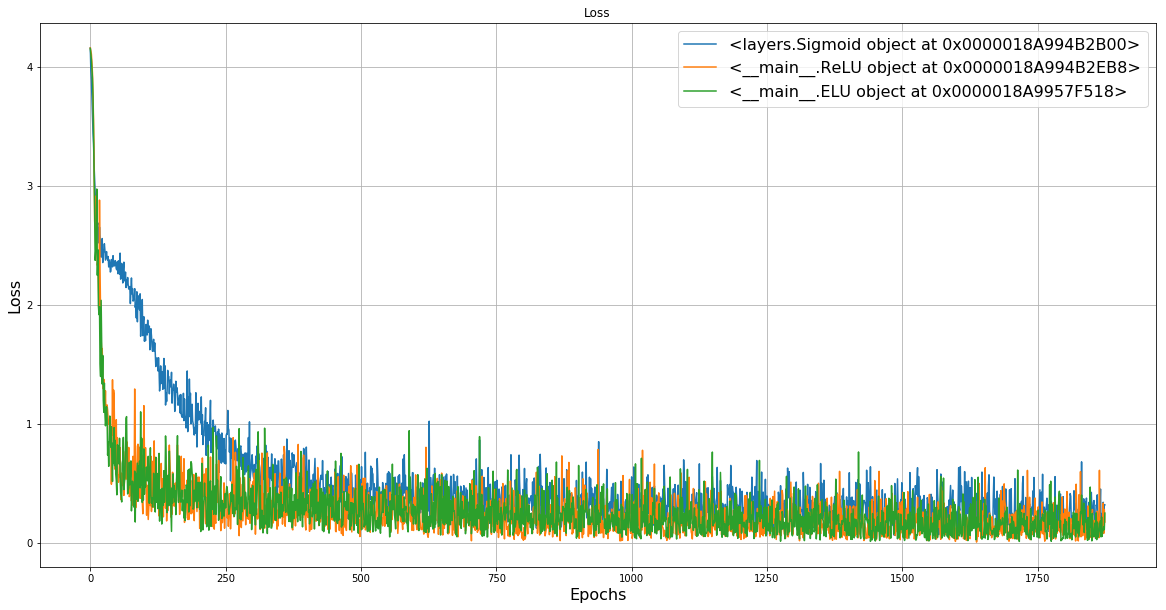

In [106]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title('Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
for activation in [Sigmoid(), ReLU(), ELU()]:
    losses = []
    net = set_net(activation)
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    plt.plot(losses, label=activation)
plt.legend(loc=0, fontsize=16)
plt.show

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Говоря о выборе нелинейности, Relu и Elu показывают одинаковый результат как на скорости сходимости, так и на Loss, Sigmoid показывает результаты хуже. Предобработка данных, получается, что не особо улучшает скорость сходимости и Loss.